In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Now Explicit ADR

In [25]:
def _AD_matrix(cfld, cfla, PHI, NX, Nsteps):
    T = np.zeros([NX,NX])
    T[0][0] = 1
    T[-1][-1] = 1
    
    a = cfld + cfla/2
    b = cfld - cfla/2
    c = 1-2*cfld

    for n in range(1,NX-1):
        T[n][n-1]=a
        T[n][n]=c
        T[n][n+1]=b
        
    f = np.zeros([Nsteps, NX])

    sizex = 1
    dx = 1. /NX
#     print(dx)
    x = np.linspace(0,1,NX)

    sigma = .1*sizex
    f[0][1:-1] = np.exp(-.5*np.power((x[1:-1]-sizex/2)/sigma,2))
    f[0,0] = PHI
    f[0,-1] = PHI
    
    return T,f


## Let's do this with linear chemistry at first and constant advection

In [372]:

def _ADR_matrix(cfld, cfla, kappa, PHI, NX, Nsteps):
    T = np.zeros([NX,NX])
    T[0][0] = 1
    T[-1][-1] = 1
    
    a = cfld + cfla/2
    b = cfld - cfla/2
    c = 1-2*cfld + kappa

    for n in range(1,NX-1):
        T[n][n-1]=a
        T[n][n]=c
        T[n][n+1]=b
        
    f = np.zeros([Nsteps, NX])

    sizex = 1
    dx = 1. /NX
    x = np.linspace(0,1,NX)

    sigma = .1*sizex
    f[0][1:-1] = np.exp(-.5*np.power((x[1:-1]-sizex/2)/sigma,2))
    f[0,0] = PHI
    f[0,-1] = PHI
    
    return T,f

def _ADR_matrix_PBC(cfld, cfla, kappa, PHI, NX, Nsteps):

    a = cfld + cfla/2
    b = cfld - cfla/2
    c = 1-2*cfld + kappa

    T = np.zeros([NX,NX])
    T[0][0] = c
    T[-1][-1] = c
    
    T[0][1] = b
    T[-1][-2] = a
    
    T[0][-1] = a
    T[-1][0] = b
    
    for n in range(1,NX-1):
        T[n][n-1]=a
        T[n][n]=c
        T[n][n+1]=b
        
    f = np.zeros([Nsteps, NX])

    sizex = 1
    dx = 1. /NX
    x = np.linspace(0,1,NX)

    sigma = .1*sizex
    f[0][:] = np.exp(-.5*np.power((x[:]-sizex/2)/sigma,2))

    print(T)
    return T,f
def ADR_with_history(cfld, cfla, kappa, PHI, NX, Nsteps):
    T,f = _ADR_matrix_PBC(cfld, cfla, kappa, PHI, NX, Nsteps)
    dx    = 1/float(NX-1)
    x = np.linspace(0,1,NX)

    for t in range(1,Nsteps):
        f[t] = np.dot(T,f[t-1])
    return x, f
def plot_10_percent(x,f):
    lw = 2
    
    stepsize = np.floor(f.shape[0]/10)
    plt.figure(figsize = (9,9))
    # plt.plot(x,f[0],'k--',alpha = 1, lw = lw+.5,label = 0)
    for step in np.arange(0,f.shape[0],stepsize):
        plt.plot(x,f[step],'k',alpha = .9*step/f.shape[0]+.1, lw = lw, label = np.int(step))

#     plt.ylim([0,1])
    plt.xlabel('x')
    plt.legend(fontsize = 14)
    plt.show()
# %time diffusion_fast(.4,1,100,34000)
def calc_H(f,dx):
    tot = 0
    for i in f.flatten():
        tot += i*i*dx
    return tot
def calc_M0(f,dx):
    tot =0
    for i in f.flatten():
        tot += i*dx
    return tot
def calc_M1(f,x,dx):
    return np.dot(f,x*dx)

def norm(x):
    np.array(x)
    x/=np.max(x)
    return x
def unit_H(f, dx, M0):
    tot = 0 
    for i in f.flatten():
        tot += i*i**dx/M0

def diag(x,f):
    dx = x[1]-x[0]
    list_H = []
    list_M0 = []
    list_M1 = []
    list_unit_H = []
    for i in range(len(f)-1):
        list_H.append(calc_H(f[i],dx))
        list_M0.append(calc_M0(f[i],dx))
        list_M1.append(calc_M1(f[i],x,dx))
        list_unit_H.append(unit_H(f[i],dx,list_M0[-1]))
#     print(M0_prime)
    print(list_H[1:6])
    plt.figure(figsize =(9,9))
    plt.plot(list(range(len(f)-1)),norm(list_H),'k',lw=5 , label = r"$H_2$")
    plt.plot(list(range(len(f)-1)),norm(list_M0),':',lw=5 , label = r"$M_0$")
#     plt.plot(list(range(len(f)-1)),norm(list_M0),':',lw=5 , label = r"$M_0$")
    plt.plot(list(range(len(f)-1)),norm(list_unit_H),':',lw=5 , label = r"$M_0$")

#     plt.plot(list(range(len(f)-2)),norm(M0_prime),label = 'M0_prime')
#     plt.plot(list(range(len(f)-1)),norm(list_M1),'--',lw=5 , label = r"$M_1$")
#     print(np.array(list_M1)-np.array(list_M0))
    print(norm(list_M1))
    fs = 20
    plt.ylabel("Normalized Value",fontsize =fs)
    plt.legend(fontsize = fs)

    plt.xlabel("Time step",fontsize = fs)
    plt.show()
    return list(range(len(f)-1)), list_M0, list_M1, list_H, list_unit_H
def init(Nsteps, NX,sizeX):
    sigma = .1*sizeX
    x = np.linspace(0,sizeX,NX)
    f = np.zeros([Nsteps, NX])
    f[0][:] = np.exp(-.5*np.power((x[:]-sizeX/2)/sigma,2))
    return x,f


5.10152025304e-05
[[ 0.5         0.24772727  0.         ...,  0.          0.          0.25227273]
 [ 0.25227273  0.5         0.24772727 ...,  0.          0.          0.        ]
 [ 0.          0.25227273  0.5        ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.5         0.24772727  0.        ]
 [ 0.          0.          0.         ...,  0.25227273  0.5         0.24772727]
 [ 0.24772727  0.          0.         ...,  0.          0.25227273  0.5       ]]


/home/ian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


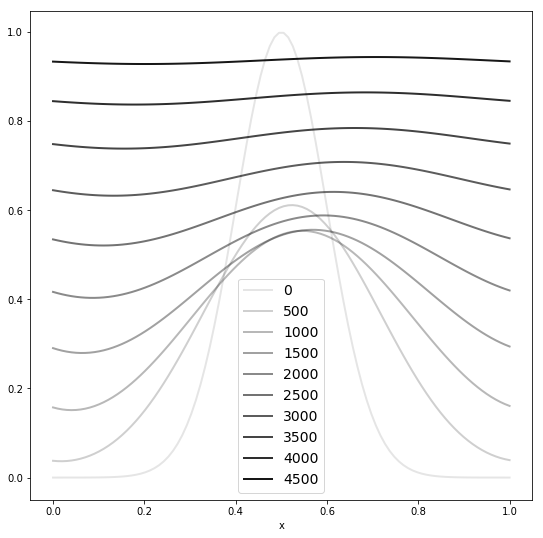

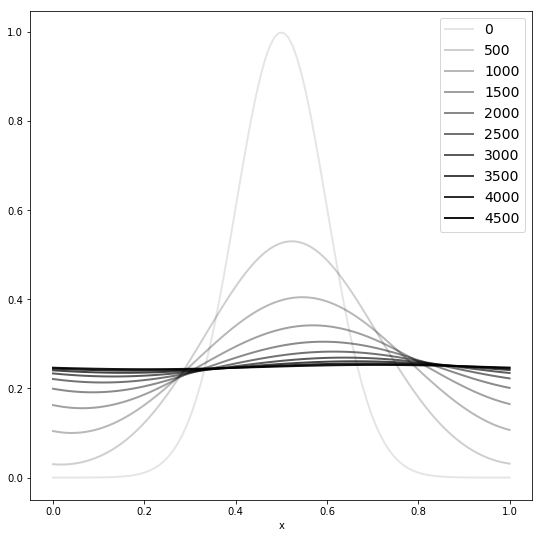

[0.17687216821347759, 0.17650234655145544, 0.17613587529581543, 0.1757727104634032, 0.17541280887691404]


TypeError: unorderable types: NoneType() >= NoneType()

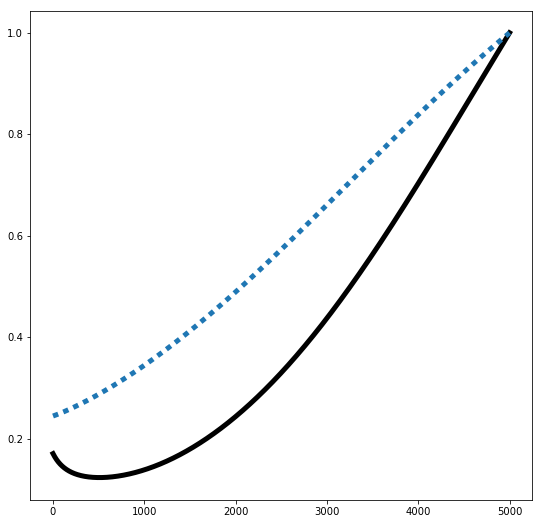

In [373]:
dif = 0.5
vel = 0.9
sizeX = 1
Nsteps = 5000
NX = 100
dx = sizeX/(NX-1)
x = np.linspace(0,sizeX,NX)
sigma = .1*sizeX

f = np.zeros([Nsteps, NX])
f_AD = np.zeros([Nsteps, NX])
f[0][:] = np.exp(-.5*np.power((x[:]-sizeX/2)/sigma,2))
f_AD[0][:] = np.exp(-.5*np.power((x[:]-sizeX/2)/sigma,2))

logis_a = 10
logis_b = 7
dt_dif  = dx*dx/dif
dt_adv  = dx/vel 
if logis_a != 0:
    dt_chem = 1/logis_a
dt = .25*np.min([dt_dif, dt_adv, dt_chem])

alpha = vel*dt/dx
delta = dif*dt/(dx*dx)
# with logistic kappa will be constantly changing
#kappa = 
print(dt)

a = delta + .5*alpha
b = delta -.5*alpha
c = 1-a-b

T_base = np.zeros([NX,NX])
T_base[0][0] = c
T_base[-1][-1] = c

T_base[0][1] = b
T_base[-1][-2] = a

T_base[0][-1] = a
T_base[-1][0] = b

for n in range(1,NX-1):
    T_base[n][n-1]=a
    T_base[n][n]=c
    T_base[n][n+1]=b
    

chem = (logis_a-logis_b)*f[0]*dt
T = T_base +chem*np.identity(NX)
print(T)
for it in range(1,Nsteps):
    chem = (logis_a-logis_b*f[it-1])*dt
    T = T_base + chem*np.identity(NX)
    f[it] = np.dot(T,f[it-1])
for it in range(1,Nsteps):
    f_AD[it] = np.dot(T_base,f_AD[it-1])
plot_10_percent(x,f)
plot_10_percent(x,f_AD)
out = diag(x,f)
out = diag(x,f_AD)

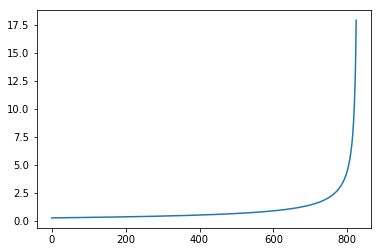

In [238]:
max_v = 825
plt.plot(out[0][:max_v],out[1][:max_v])


In [197]:
a = delta + .5*alpha
b = delta -.5*alpha
c = 1-a-b

T_base = np.zeros([NX,NX])
T_base[0][0] = c
T_base[-1][-1] = c

T_base[0][1] = b
T_base[-1][-2] = a

T_base[0][-1] = a
T_base[-1][0] = b

for n in range(1,NX-1):
    T_base[n][n-1]=a
    T_base[n][n]=c
    T_base[n][n+1]=b
    

chem = (logis_a-logis_b)*f[0]*dt
T = T_base +chem*np.identity(NX)
for it in range(1,Nsteps):
    chem = (logis_a-logis_b)*f[it-1]*dt
    T = T_base + chem*np.identity(NX)
    f[it] = np.dot(T,f[it-1])
plot_10_percent(x,f)
out = diag(x,f)

[[ 0.5         0.24873737  0.         ...,  0.          0.          0.25126263]
 [ 0.25126263  0.5         0.24873737 ...,  0.          0.          0.        ]
 [ 0.          0.25126263  0.5        ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.5         0.24873737  0.        ]
 [ 0.          0.          0.         ...,  0.25126263  0.5         0.24873737]
 [ 0.24873737  0.          0.         ...,  0.          0.25126263  0.5       ]]


IndexError: index 500 is out of bounds for axis 0 with size 500

In [124]:
tot = 0
for i in range(NX):
    tot += f[0][i]*x[i]*dx
print(tot*4)

0.501325436487


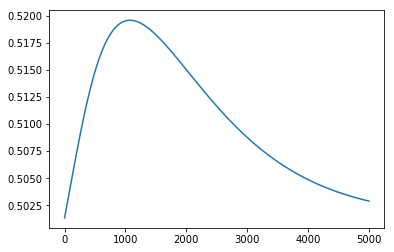

In [128]:
plt.plot(out[0],np.array(out[3])*4)
# plt.plot(out[0][0:-1],out[2])
# plt.plot(out[0],out[-1])

[[ 0.605  0.1    0.    ...,  0.     0.     0.3  ]
 [ 0.3    0.605  0.1   ...,  0.     0.     0.   ]
 [ 0.     0.3    0.605 ...,  0.     0.     0.   ]
 ..., 
 [ 0.     0.     0.    ...,  0.605  0.1    0.   ]
 [ 0.     0.     0.    ...,  0.3    0.605  0.1  ]
 [ 0.1    0.     0.    ...,  0.     0.3    0.605]]
(500, 100)


/home/ian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


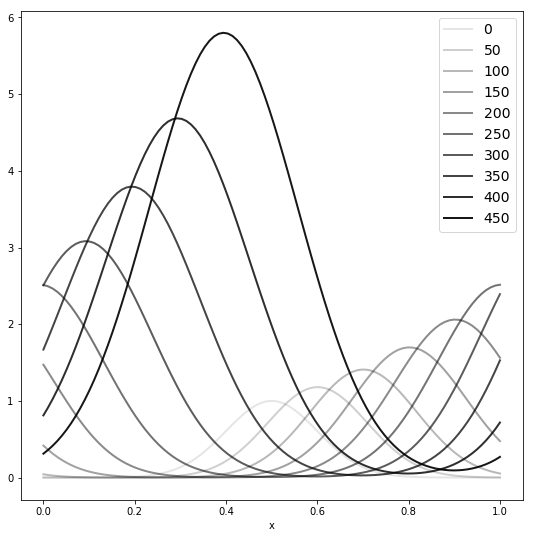

In [196]:
x,f = ADR_with_history(.2, .2, .005, 1,100, 500)
print(f.shape)
plot_10_percent(x,f)

# Does chem commute with AD

/home/ian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


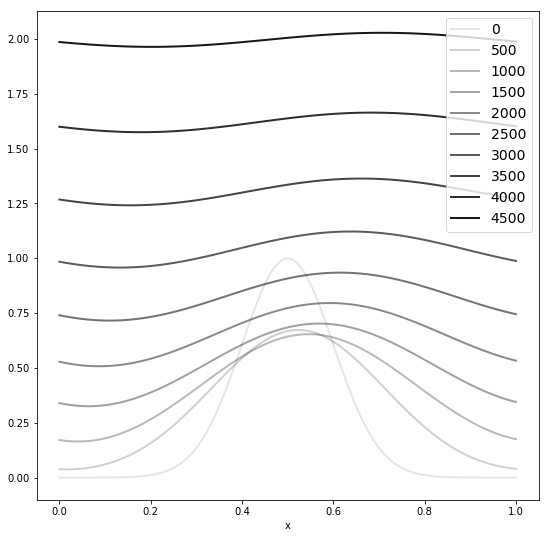

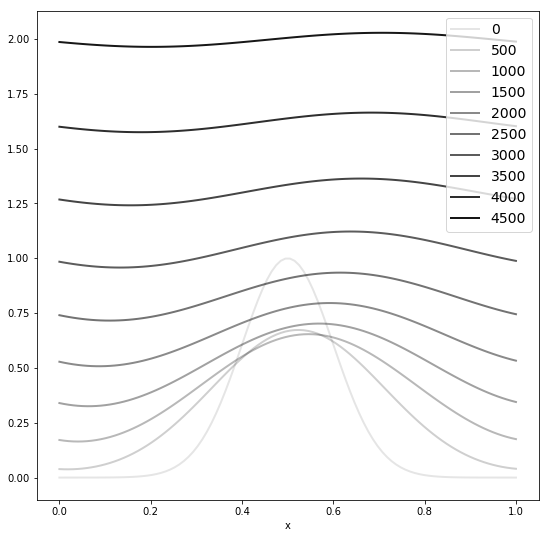

array([ -3.07342244e-05,  -3.10607432e-05,  -3.13754925e-05,
        -3.16772416e-05,  -3.19648128e-05,  -3.22370862e-05,
        -3.24930041e-05,  -3.27315744e-05,  -3.29518745e-05,
        -3.31530547e-05,  -3.33343411e-05,  -3.34950386e-05,
        -3.36345328e-05,  -3.37522927e-05,  -3.38478720e-05,
        -3.39209111e-05,  -3.39711377e-05,  -3.39983679e-05,
        -3.40025066e-05,  -3.39835479e-05,  -3.39415746e-05,
        -3.38767581e-05,  -3.37893573e-05,  -3.36797180e-05,
        -3.35482708e-05,  -3.33955302e-05,  -3.32220922e-05,
        -3.30286320e-05,  -3.28159019e-05,  -3.25847279e-05,
        -3.23360074e-05,  -3.20707051e-05,  -3.17898501e-05,
        -3.14945317e-05,  -3.11858958e-05,  -3.08651403e-05,
        -3.05335107e-05,  -3.01922961e-05,  -2.98428235e-05,
        -2.94864537e-05,  -2.91245757e-05,  -2.87586017e-05,
        -2.83899619e-05,  -2.80200986e-05,  -2.76504613e-05,
        -2.72825008e-05,  -2.69176637e-05,  -2.65573866e-05,
        -2.62030909e-05,

In [250]:
a = delta + .5*alpha
b = delta -.5*alpha
c = 1-a-b

T_base = np.zeros([NX,NX])
T_base[0][0] = c
T_base[-1][-1] = c

T_base[0][1] = b
T_base[-1][-2] = a

T_base[0][-1] = a
T_base[-1][0] = b

for n in range(1,NX-1):
    T_base[n][n-1]=a
    T_base[n][n]=c
    T_base[n][n+1]=b
Nsteps = 5000
x,f_AD_R = init(Nsteps, NX, sizeX)
x,f_R_AD = init(Nsteps, NX, sizeX)
logis_a = 10
logis_b = 1

for it in range(1,Nsteps):
    chem = (logis_a-logis_b*f_AD_R[it-1])*dt
    T_chem = np.identity(NX) + chem*np.identity(NX)
    f_AD_R[it] = np.dot(T_base,f_AD_R[it-1])
    f_AD_R[it] = np.dot(T_chem,f_AD_R[it])
    
for it in range(1,Nsteps):
    chem = (logis_a-logis_b*f_R_AD[it-1])*dt
    T_chem = np.identity(NX) + chem*np.identity(NX)
    f_R_AD[it] = np.dot(T_chem,f_R_AD[it-1])
    f_R_AD[it] = np.dot(T_base,f_R_AD[it])

plot_10_percent(x,f_AD_R)
plot_10_percent(x,f_R_AD)
f_R_AD[-1]-f_AD_R[-1]

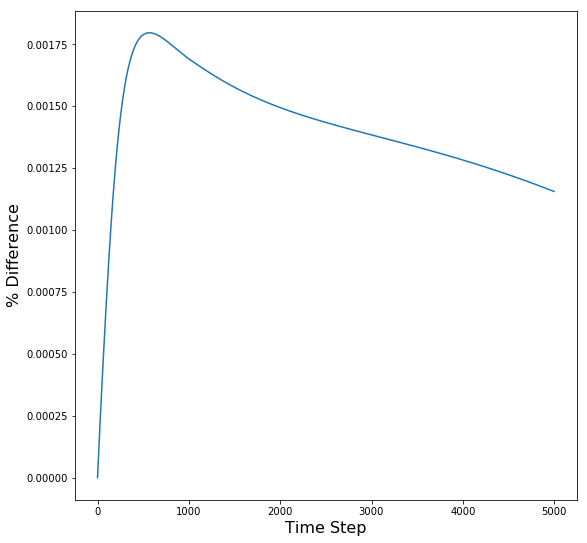

In [375]:
abs_dif = np.sum(np.abs(f_R_AD-f_AD_R),axis=1)
rel_dif = np.sum(np.abs(f_R_AD-f_AD_R)/f_R_AD,axis=1)/f_R_AD.shape[1]
plt.figure(figsize = (9,9))
plt.plot(list(range(len(abs_dif))),rel_dif*100)
plt.ylabel("% Difference",fontsize = 16)
plt.xlabel("Time Step", fontsize = 16)
plt.show()

In [356]:
print(abs_dif)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.87688949e-16   3.75997078e-16   9.55793672e-16 ...,   9.84492842e-16
    3.87112692e-16   1.91132138e-16]
 [  4.14297367e-16   8.97169674e-16   2.21550276e-15 ...,   2.30073291e-15
    9.29979496e-16   4.23153096e-16]
 ..., 
 [  3.07237462e-05   3.10503080e-05   3.13650830e-05 ...,   2.96863502e-05
    3.00404245e-05   3.03866772e-05]
 [  3.07289856e-05   3.10555259e-05   3.13702882e-05 ...,   2.96917054e-05
    3.00457326e-05   3.03919467e-05]
 [  3.07342244e-05   3.10607432e-05   3.13754925e-05 ...,   2.96970604e-05
    3.00510404e-05   3.03972157e-05]]


# Implicit Crank-Nicolson
With doing chemistry then AD as separate steps because we can separate the operators

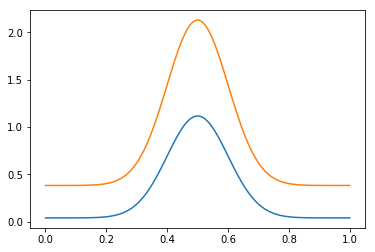

In [150]:
#start with just chemistry
h = dt
logis_a  = 1
logis_b = .01
def chem(f):
    return logis_a*f-logis_b*f*f
for it in range(Nsteps-1):
    f[it+1] = f[it] + chem(f[it])*h
    f[it+1] = f[it] + chem(f[it])*h/2+chem(f[it]+1)*h/2
plt.plot(x,f[600])
plt.plot(x,f[4500])

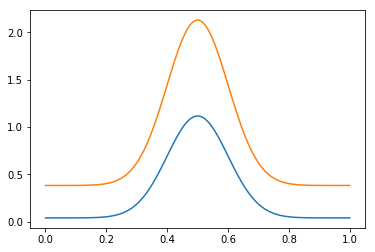

In [149]:
# exponential integration

for it in range(1,Nsteps):
    for j in range(NX):
        

# Simple ODE + Adaptive time stepping

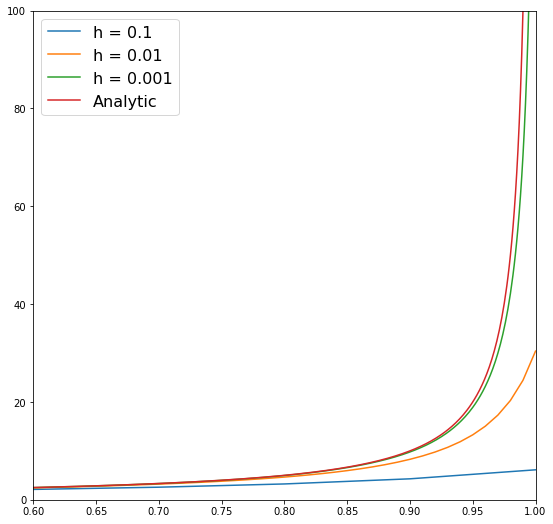

In [288]:
def calc_ode(t, h, x0):
    N_steps = np.int(t/h)
    x = np.zeros([N_steps+1])
    t = np.linspace(0,1,N_steps+1)
    x[0] = x0
    for i in range(1,N_steps+1):
        x[i] = h*x[i-1]**2+x[i-1]
    return t,x
def x_t(t,x0):
    return x0/(1-x0*t)

plt.figure(figsize=(9,9))
t,x = calc_ode(1,.1,1)
plt.plot(t,x,label = "h = {:}".format(t[1]-t[0]))

t,x = calc_ode(1,.01,1)
plt.plot(t,x,label = "h = {:}".format(t[1]-t[0]))

t,x = calc_ode(1,.001,1)
plt.plot(t,x,label = "h = {:}".format(t[1]-t[0]))


t = np.linspace(0,.99,N_steps)
plt.plot(t,x_t(t,x0),label = "Analytic")
plt.ylim([0,100])
plt.xlim([.6,1])
plt.legend(fontsize = 16)

/home/ian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


(0, 100)

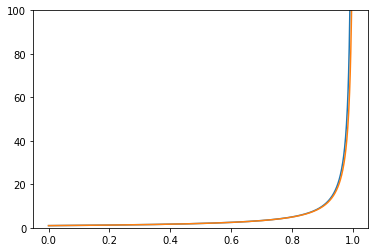

In [264]:
def calc_h(h_cur, h_old, q, epsilon, y_cur, y_old):
    return q*(h_old-h_cur)*epsilon/np.abs(y_cur-y_abs)

In [343]:
# adapative a la sauro


def calc_ode_adap(t, epsilon, x0,q):
    
    h = epsilon*x0*q
    x = np.zeros([N_steps+1])
    time_list = [0]
    n_steps = 0
    x = [x0]
    i = 0
    while time_list[-1] < 1:
        i += 1
        time_list.append(time_list[-1]+h)
        x.append(h*x[i-1]**2+x[i-1])
        if h < epsilon/x[i]:
            h = epsilon *q/ x[i]
    return time_list,x

17
178
1787


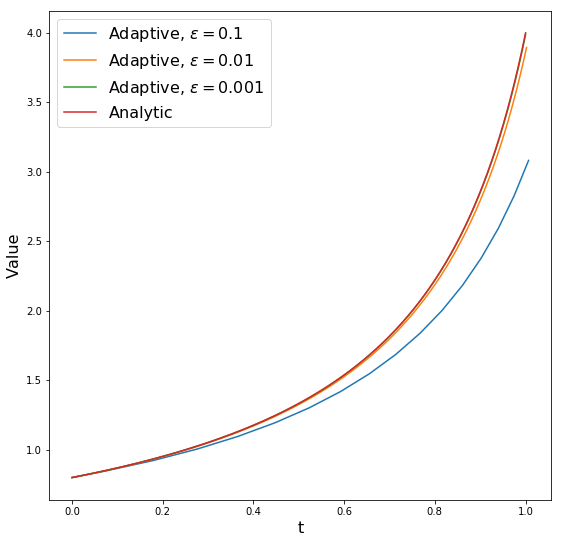

In [377]:
plt.figure(figsize=(9,9))
x0 = .8
eps = .1
t,x = calc_ode_adap(1,eps,x0,q=.9)
print(len(t))
plt.plot(t,x,label = r"Adaptive, $\epsilon = {:}$".format(eps))

eps = .01
t,x = calc_ode_adap(1,eps,x0,q=.9)
print(len(t))
plt.plot(t,x,label = r"Adaptive, $\epsilon = {:}$".format(eps))

eps = .001
t,x = calc_ode_adap(1,eps,x0,q=.9)
print(len(t))
plt.plot(t,x,label = r"Adaptive, $\epsilon = {:}$".format(eps))


t = np.linspace(0,1,N_steps)
plt.plot(t,x_t(t,x0),label = "Analytic")
# plt.ylim([0,100])
# plt.xlim([.6,1])
plt.ylabel("Value",fontsize = 16)
plt.xlabel("t",fontsize = 16)
plt.legend(fontsize = 16)

# ADR in 2D

In [ ]:
def ADR_2D_update(t,f,i,j):
    a = cfld
    b = cfld
    c = 1-4*cfld
    f[t,i,j]  = a*f[t-1,i-1,j]+b*f[t-1,i+1,j]
    f[t,i,j] += a*f[t-1,i,j-1]+b*f[t-1,i,j+1]
    f[t,i,j] += c*f[t-1,i,j]